<a href="https://colab.research.google.com/github/deepk2001/Duolingo-Reviews-Data-Analysis/blob/main/Practicum_Duolingo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

We have chosen **Duolingo** app on Google Play Store for our Practicum for the following reasons:

1. Popular app, therefore has an abundance of reviews and users
2. Familiarity, the team is familiar with Duolingo's operations and therefore can really relate to user's reviews about the app
3. Regular updates, The app has rolled out regular patch, minor and the occasional major updates.

Below we have code that performs the basic data collection using a popular library for scraping data on google play store.

# Install Packges

In [5]:
!pip install pandas
!pip install google-play-scraper

# Fetch reviews and store in CSV
To fetch the data we use the given library function and we fetch 60,000 reviews sorted by relevance.

**Note**: We have elected to use relevance as a sorting feature to be able to ensure that we can have a good balance between review types and relevant reviews may have more actionable information.

The returned reviews are plugged into a Data Frame with focus on base columns like ['userName', 'score', 'content', 'at', 'appVersion'].

These columns were picked as they have provided vital information regarding the reviews left by app users.


In [6]:
from google_play_scraper import reviews, Sort
import pandas as pd

app_id = "com.duolingo"  # Duolingo app ID

def fetch_reviews_by_sort(app_id, sort_type, count=1000):
    result, _ = reviews(
        app_id=app_id,
        lang='en',
        country='us',
        sort=sort_type,
        count=count
    )

    df = pd.DataFrame(result)
    df['sort_type'] = sort_type.name  # Track source
    return df


# Fetch most relevant reviews
df = fetch_reviews_by_sort(app_id, Sort.MOST_RELEVANT, count=60000)

columns =['userName', 'score', 'content', 'at', 'appVersion']

# Keep relevant columns
df = df[columns]

df.to_csv("duolingo_reviews.csv", index=False)

print(df.head())

        userName  score                                            content  \
0  A Google user      1  first off I'm on a 392 day streak so I've used...   
1  A Google user      3  As long as I get energy back from watching ads...   
2  A Google user      1  I have a 1,364-day streak. I just got switched...   
3  A Google user      2  I was always on the fence if I wanted to keep ...   
4  A Google user      1  I have been using Duolingo for ~7 years. I hav...   

                   at appVersion  
0 2025-12-19 01:19:02     6.59.4  
1 2026-01-06 21:06:15     6.60.6  
2 2025-10-01 04:22:38     6.49.3  
3 2025-10-03 03:25:48     6.50.2  
4 2025-10-02 17:15:54     6.50.2  


# Data Cleaning

To clean the data, we have followed the following steps:
1. Removal of duplicate reviews.
2. We remove any data that has a nullable value within any of our base columns.
3. we create a new column cleaned_content that is the content column without the stopwords and any links. We also convert the text into lowercase to standardize it.
4. We once again remove any data points that have nullable cleaned_content.

In [7]:
# remove duplicates
df.drop_duplicates(subset='content', inplace=True)

# remove null values

for column in columns:
  df = df[df[column].notnull()]

#standardize text

import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_content'] = df['content'].apply(clean_text)

#clean review out that have no cleaned_content
df = df[df["cleaned_content"].notnull()]
df = df[df['cleaned_content'].str.strip() != ""]


#make sure date is in datetime format

df['at'] = pd.to_datetime(df['at'])
dateRange = (df["at"].min(), df['at'].max())
versionRange = (df["appVersion"].min(),df["appVersion"].max())
print( "Time Interval of data: ",dateRange)
print("Number of Data Points: ", len(df))
print("Version Interval of data: ", versionRange)


Time Interval of data:  (Timestamp('2018-09-12 12:23:25'), Timestamp('2026-02-21 14:40:58'))
Number of Data Points:  57374
Version Interval of data:  ('2.0.2', '6.9.5')


In [8]:
!pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# Exploring and Analysing the data

1. Word Frequency:
We look at the word frequency by analysing the 50 most frequent words. We can already understand that the frequency of neutral and positive words will dominate. But we are more interested in understanding the common themes in user reviews.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    stop_words='english',
    max_features=50
)

X = vectorizer.fit_transform(df['cleaned_content'])
word_counts = X.sum(axis=0)
words = vectorizer.get_feature_names_out()

freq_df = pd.DataFrame({
    'word': words,
    'frequency': word_counts.tolist()[0]
}).sort_values(by='frequency', ascending=False)

print(freq_df)

         word  frequency
1         app      44270
23   learning      26469
22      learn      22576
20   language      20368
7    duolingo      17073
9      energy      14845
26       like      13827
13       good      13221
32        new      12816
18       just      11546
25    lessons      11437
36     really      11287
21  languages      10645
16         im      10581
6        dont       9213
12        fun       8448
14      great       8425
11       free       8156
24     lesson       8118
41       time       8065
0         ads       7977
15     hearts       7563
48        way       7469
43        use       7055
28       love       7027
4         day       6643
47       want       6376
29       make       6081
49      words       5800
45      using       5697
44       used       5658
10    english       5430
17        ive       5426
42     update       5086
2        best       5019
8        easy       4939
33        pay       4623
38     streak       4611
35   practice       4429


## Word Frequency findings:

1. As expected the words are more over postive and neutral domain. However some themes have begun to emerge.
2. Energy is very common word, contextually implying that a common theme of reviews is the energy feature introduced in version 6 and after.
3. other words like ads and pay imply issues regarding the experieces with these instances of the app.


In [10]:
from datetime import datetime, timedelta

five_months_ago = datetime.now() - timedelta(days=150)
recent_reviews = df[df['at'] >= five_months_ago]

In [11]:
df['month'] = df['at'].dt.to_period('M')
monthly_counts = df.groupby('month').size()
print(monthly_counts)

month
2018-09      41
2018-10      62
2018-11      51
2018-12      76
2019-01     145
           ... 
2025-10    8185
2025-11    5704
2025-12    9397
2026-01    9464
2026-02    5823
Freq: M, Length: 90, dtype: int64


## Monthly reviews count:

1. The reviews have spiked recently as compared to before.
2. The spike is disproportionate with respect to increase in users.
3. The recent updates have excited the users.

In [12]:
monthly_rating = df.groupby('month')['score'].mean()
print(monthly_rating)

month
2018-09    4.097561
2018-10    4.145161
2018-11    4.333333
2018-12    4.065789
2019-01    3.855172
             ...   
2025-10    2.250458
2025-11    3.016830
2025-12    3.972332
2026-01    4.046492
2026-02    4.087412
Freq: M, Name: score, Length: 90, dtype: float64


# Sentiment Analysis


To analyze user reviews, the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis model was selected due to its suitability for short, informal text data such as mobile application reviews.

VADER is a lexicon and rule-based sentiment analysis tool specifically designed for social media and user-generated content. Unlike traditional machine learning models, it does not require labeled training data, making it computationally efficient and easy to implement for large-scale review datasets.

One of the primary reasons for choosing VADER is its ability to handle linguistic nuances commonly found in app reviews, including:

- Emphasis through capitalization (e.g., "THIS UPDATE IS TERRIBLE")
- Repeated punctuation (e.g., "awful!!!")
- Degree modifiers (e.g., "very bad", "extremely slow")
- Negations (e.g., "not good")
- Informal language and short expressions

VADER produces four sentiment metrics: positive, negative, neutral, and a compound score. The compound score ranges from -1 to +1 and represents the normalized overall sentiment of a review.

In this study, the compound score was used for classification as follows:

- Compound ≥ 0.05 → Positive  
- Compound ≤ -0.05 → Negative  
- Otherwise → Neutral  

The compound score was particularly useful for downstream analysis, including clustering negative reviews and identifying major complaint themes across specific time periods and app version updates.

Given the nature of the dataset—short, emotionally expressive app reviews—VADER provides a reliable, interpretable, and computationally efficient approach for sentiment classification.

In [13]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.4 MB/s eta 0:00:00


In [14]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

df['sentiment_score'] = df['cleaned_content'].apply(get_sentiment)

def sentiment_label(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['sentiment_score'].apply(sentiment_label)
negative_reviews = df[df['sentiment'] == 'Negative'].copy()
neutral_reviews = df[df['sentiment'] == 'Neutral'].copy()
positive_reviews = df[df['sentiment'] == 'Positive'].copy()



# Distribution of Reviews

Based on the sentiment assigned by our parameters at Vader. The next step is to visualize the reviews and understand any focus regions that can help us understand the negative review themes better.

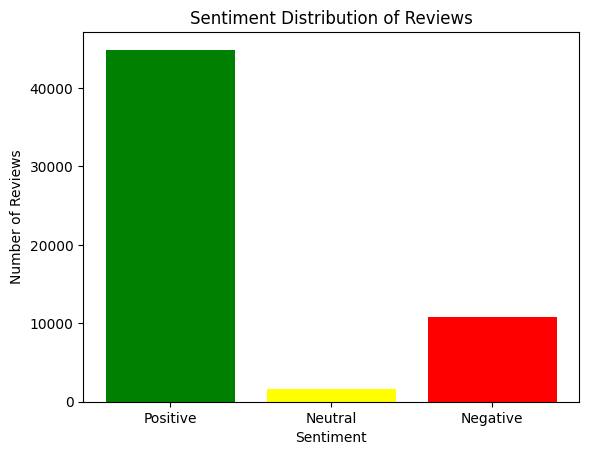

In [15]:
import matplotlib.pyplot as plt

# Count sentiment categories
sentiment_counts = df['sentiment'].value_counts()

# Ensure consistent order
sentiment_counts = sentiment_counts.reindex(['Positive', 'Neutral', 'Negative']).fillna(0)

colors = ['green', 'yellow', 'red']

# Create bar plot
plt.figure()
plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)

plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.title("Sentiment Distribution of Reviews")

plt.show()

## Simple Distribution Analysis:

1. The simple count distribution suggests that majority of app users have been in favor of the app updates and experience.
2. A major focus is that there is a lack of Neutral reviews, which means that the average user is either content with the app or incontent.
3. We need to plot it based on version and months to understand the trends better.

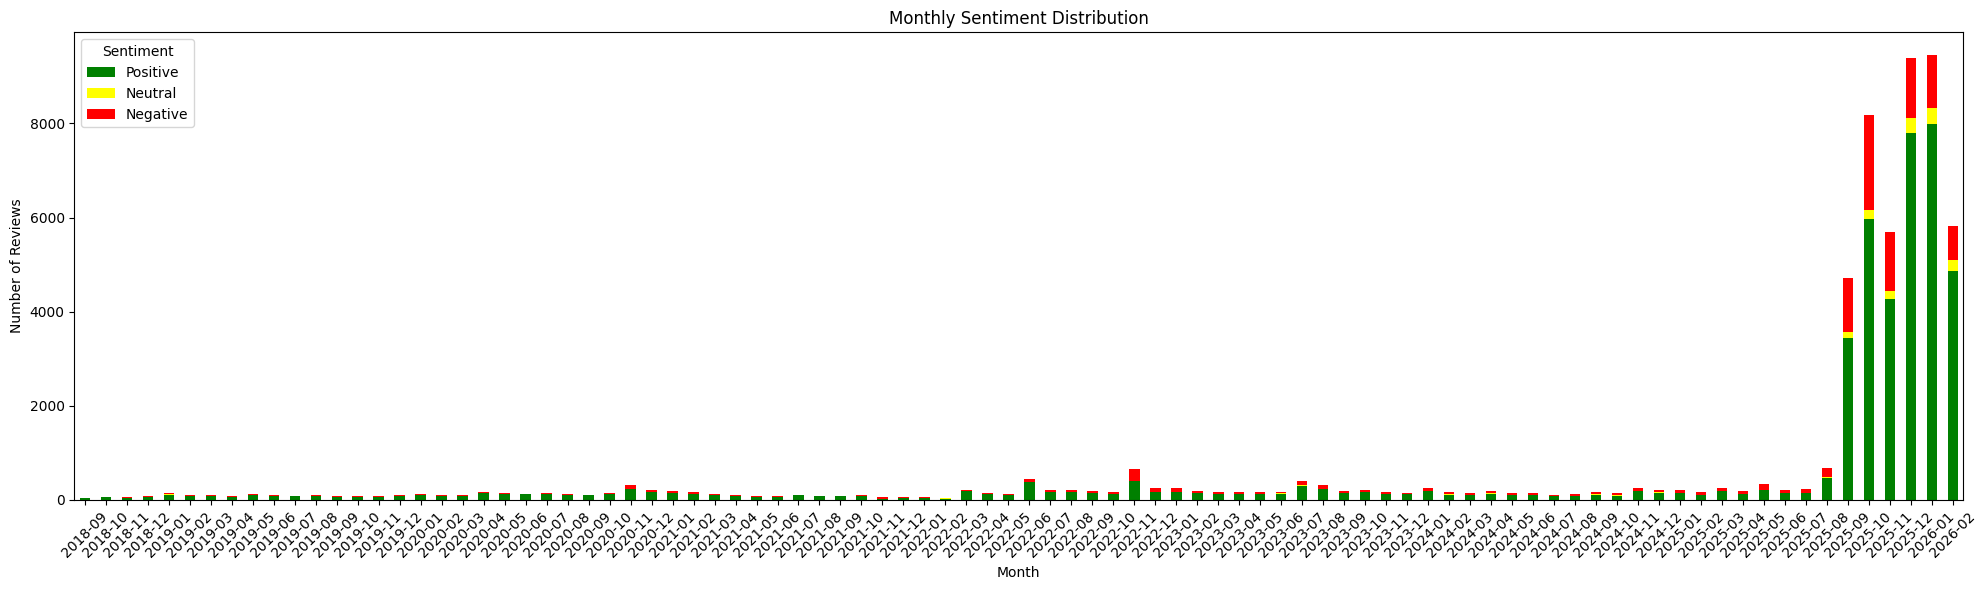

In [16]:
df['at'] = pd.to_datetime(df['at'])

# Extract month (year-month)
df['month'] = df['at'].dt.to_period('M')

# Count of each sentiment per month
monthly_sentiment = df.groupby(['month', 'sentiment']).size().unstack(fill_value=0)

# Ensure consistent order for sentiment columns
monthly_sentiment = monthly_sentiment[['Positive', 'Neutral', 'Negative']]

# Plot
monthly_sentiment.plot(
    kind='bar',
    stacked=True,
    color=['green', 'yellow', 'red'],
    figsize=(20,6)
)

plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Monthly Sentiment Distribution")
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

## Monthly Distribution Analysis:
1. The spike in recent reviewer activity is very evident.
2. What is also to be understood is that recently the number of negative reviews have increased manyfold.

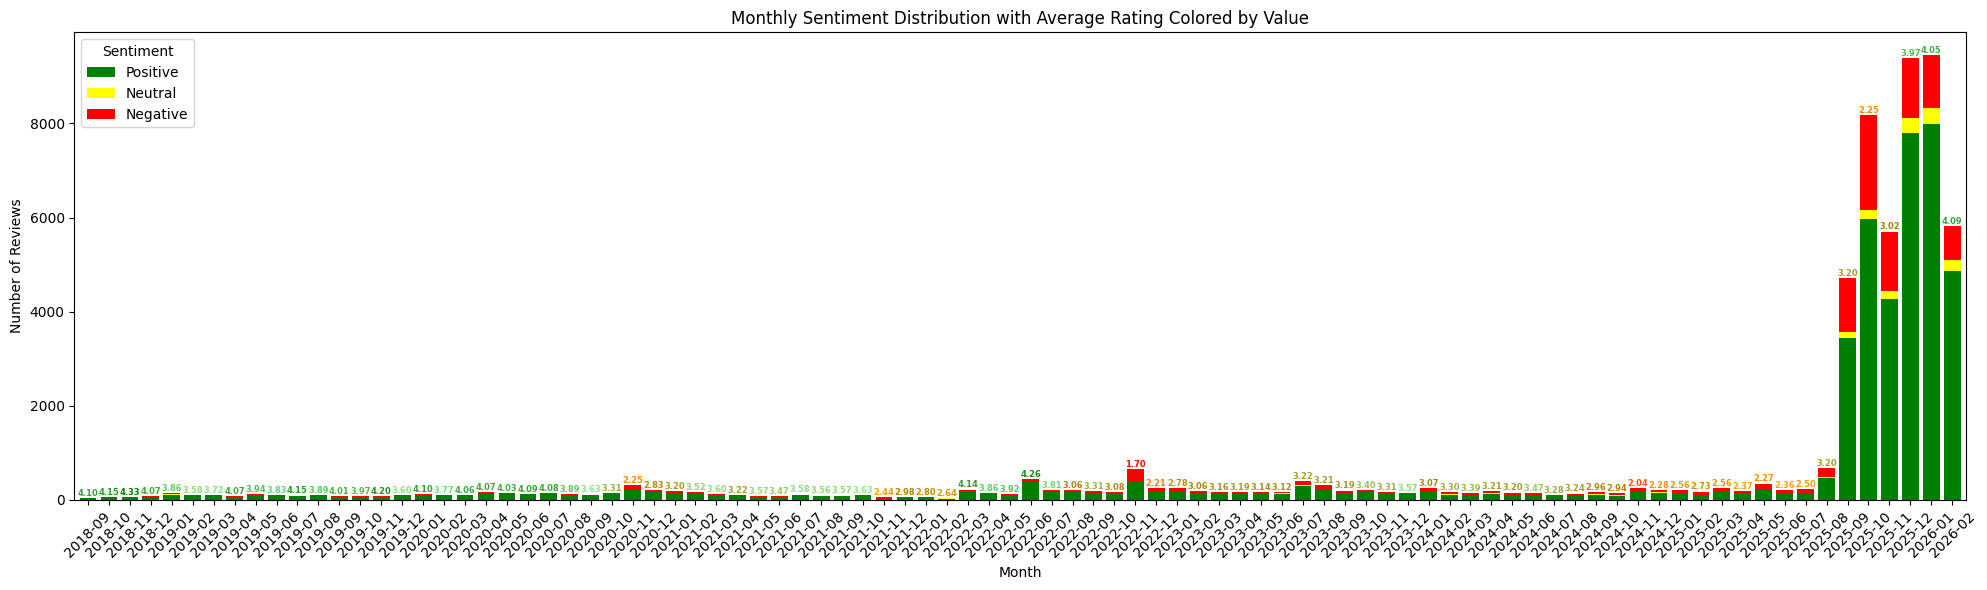

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap, Normalize

# Ensure datetime
df['at'] = pd.to_datetime(df['at'])

# Extract month
df['month'] = df['at'].dt.to_period('M')

# Count sentiment per month
monthly_sentiment = df.groupby(['month', 'sentiment']).size().unstack(fill_value=0)
monthly_sentiment = monthly_sentiment[['Positive', 'Neutral', 'Negative']]

# Calculate average rating per month
avg_rating = df.groupby('month')['score'].mean().reindex(monthly_sentiment.index)

# Define gradient colormap: red -> orange -> yellow -> light green -> dark green
colors = ['red', 'orange', '#a88100', 'lightgreen', 'green']
cmap = LinearSegmentedColormap.from_list('rating_cmap', colors)

# Normalize rating for colormap
norm = Normalize(vmin=avg_rating.min(), vmax=avg_rating.max())
rating_colors = [cmap(norm(r)) for r in avg_rating]

# Plot stacked bar
ax = monthly_sentiment.plot(
    kind='bar',
    stacked=True,
    color=['green', 'yellow', 'red'],
    figsize=(20,6),
    width=0.8
)

# Annotate average rating on top with gradient colors
for i, rating in enumerate(avg_rating):
    total_height = monthly_sentiment.iloc[i].sum()
    ax.text(
        i,
        total_height + 2,  # slightly above bar
        f"{rating:.2f}",
        ha='center',
        va='bottom',
        fontsize=6,
        fontweight='bold',
        color=rating_colors[i]
    )

plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Monthly Sentiment Distribution with Average Rating Colored by Value")
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

### Monthly Distribution with Average App rating:
The chart shows the monthly distribution of Positive, Neutral, and Negative reviews using a stacked bar format. Each bar represents total review volume, while segment sizes indicate the proportion of each sentiment category. The average monthly rating is displayed above each bar and color-coded from red (lower ratings) to green (higher ratings) for quick visual interpretation. Overall, the plot highlights shifts in user sentiment and provides a clear view of how overall ratings align with sentiment trends over time.

Points of focus:
1. Recently the app has recieved some heavy criticisms.
2. these criticisms are consistent with both sentiment analysis and trends in the rating of the app.
3. highest impact is between 2025-07 to 2026-02.
4. Let us focus more in this region.

        userName  score                                            content  \
0  A Google user      1  first off I'm on a 392 day streak so I've used...   
1  A Google user      3  As long as I get energy back from watching ads...   
2  A Google user      1  I have a 1,364-day streak. I just got switched...   
3  A Google user      2  I was always on the fence if I wanted to keep ...   
4  A Google user      1  I have been using Duolingo for ~7 years. I hav...   

                   at appVersion  \
0 2025-12-19 01:19:02     6.59.4   
1 2026-01-06 21:06:15     6.60.6   
2 2025-10-01 04:22:38     6.49.3   
3 2025-10-03 03:25:48     6.50.2   
4 2025-10-02 17:15:54     6.50.2   

                                     cleaned_content    month  \
0  first off im on a day streak so ive used it fo...  2025-12   
1  as long as i get energy back from watching ads...  2026-01   
2  i have a day streak i just got switched from t...  2025-10   
3  i was always on the fence if i wanted to keep ...  

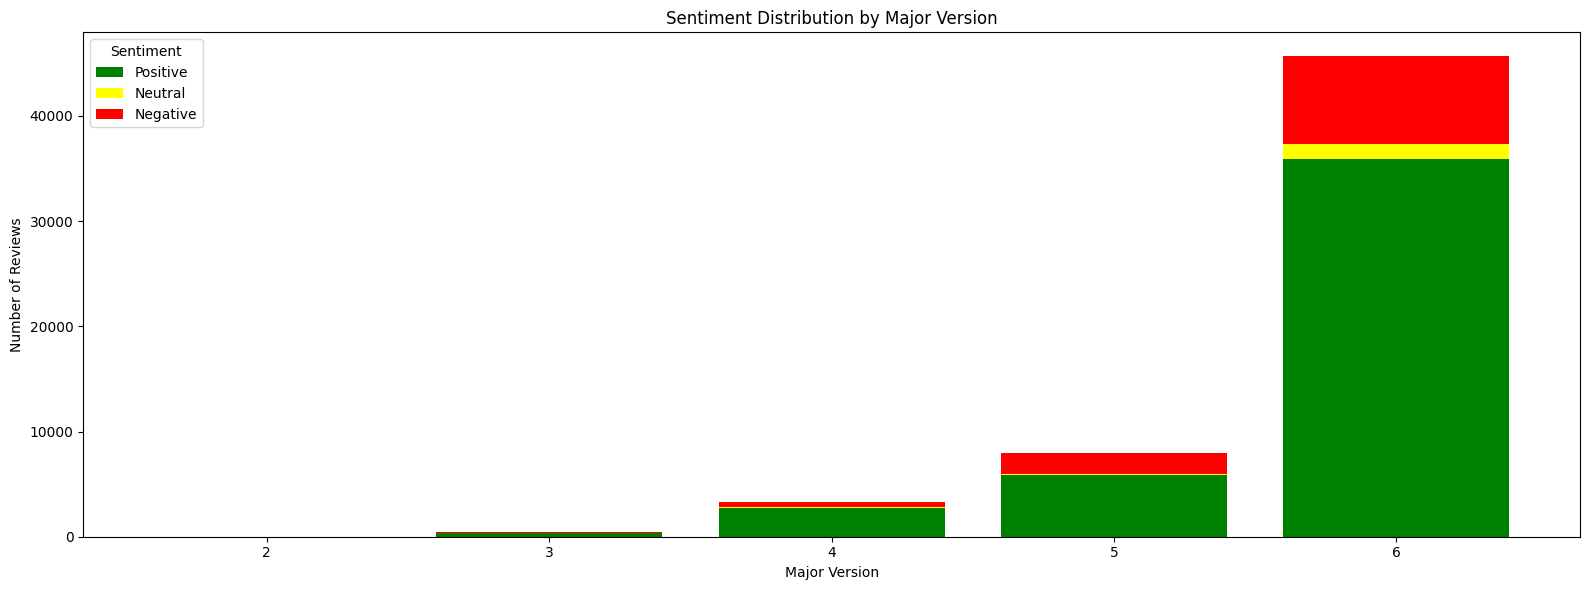

In [18]:
# Extract minor version (major + minor)
df['major_version'] = df['appVersion'].str.split('.').str[0]

# Count sentiment per minor version
minor_sentiment = df.groupby(['major_version', 'sentiment']).size().unstack(fill_value=0)
minor_sentiment = minor_sentiment[['Positive', 'Neutral', 'Negative']]
print(df.head())
# Sort numerically
minor_sentiment = minor_sentiment.sort_index(
    key=lambda x: x.map(lambda y: [int(i) for i in y.split('.')])
)

# Plot
minor_sentiment.plot(
    kind='bar',
    stacked=True,
    color=['green', 'yellow', 'red'],
    figsize=(16,6),
    width=0.8
)

plt.xlabel("Major Version")
plt.ylabel("Number of Reviews")
plt.title("Sentiment Distribution by Major Version")
plt.legend(title='Sentiment')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Version Distribution Analysis:
1. version 6 has recieved the most negative reviews.
2. This ratio suggests that the new updates to the UX have impacted some users in an undesired manner.
3. The reason for selecting major version updates over minor or patch is that as per Duo-lingo's documentation, they only make major shifts to the UX in major versions.


In [19]:
df['at'] = pd.to_datetime(df['at'])

# Filter negative reviews
negative_reviews = df[df['sentiment'] == 'Negative'].copy()

# Define date range
start_date = pd.Timestamp('2025-07-01')
end_date   = pd.Timestamp('2026-02-28')

# Filter by date
negative_reviews_range = negative_reviews[
    (negative_reviews['at'] >= start_date) & (negative_reviews['at'] <= end_date)
]

# Sort by sentiment_score ascending (most negative first)
negative_reviews_range_sorted = negative_reviews_range.sort_values(by='sentiment_score', ascending=True)

negative_reviews_range_sorted.to_csv("duolingo_reviews_negative_spike.csv", index=False)


### Focus Region
Here the focus region is updated to include only Negative reviews from the desired region.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vectorize reviews
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(negative_reviews_range_sorted['cleaned_content'])

# Compute similarity between all reviews
similarity_matrix = cosine_similarity(X)

# Example: find reviews similar to review #0
similar_indices = similarity_matrix[0].argsort()[::-1][1:6]  # top 5 similar reviews
similar_reviews = negative_reviews_range_sorted.iloc[similar_indices]

print(similar_reviews)

            userName  score  \
43528  A Google user      1   
43354  A Google user      4   
11221  A Google user      3   
10809  A Google user      4   
41982  A Google user      1   

                                                 content                  at  \
43528  absolutely hate this new icon thing that chang... 2025-09-20 05:06:24   
43354  i love the Duolingo app but the current icon o... 2025-09-28 17:52:13   
11221  the app is great for learning. I don't like ho... 2026-01-05 02:55:39   
10809  The App was good but in recent times it set on... 2025-12-09 17:59:32   
41982  I was starting to like this app again until th... 2025-11-03 02:30:35   

      appVersion                                    cleaned_content    month  \
43528     6.48.4  absolutely hate this new icon thing that chang...  2025-09   
43354     6.47.6  i love the duolingo app but the current icon o...  2025-09   
11221     6.60.6  the app is great for learning i dont like how ...  2026-01   
10809     6.

## 🔍 Clustering & Thematic Analysis of Negative Reviews

### 1. Text Extraction
- Extract cleaned negative review texts from the DataFrame.
- Convert them into a list for embedding generation.

### 2. Sentence Embedding (Semantic Representation)
- Use Sentence-BERT (`all-MiniLM-L6-v2`) to convert each review into dense vector embeddings.
- Embeddings capture contextual semantic meaning beyond simple keyword matching.

### 3. K-Means Clustering
- Apply K-Means clustering with k = 5 to group semantically similar reviews.
- Assign each review a cluster label and append it to the dataset.

### 4. Top 3 Dominant Clusters Selection
- Count reviews per cluster using `Counter`.
- Select the top 3 clusters with the highest number of reviews for focused analysis.

### 5. Cluster-Level Theme Extraction
For each of the top 3 clusters:
- Compute TF-IDF to extract top 10 representative keywords.
- Calculate the cluster centroid in embedding space.
- Measure cosine similarity between each review and the centroid.
- Select the top 3 most representative reviews (closest to centroid).
- Truncate long reviews for concise reporting.

### 6. Cluster Summary Generation
- Combine keywords and representative reviews into a structured summary.
- Display cluster size, key themes, and sample reviews.

In [22]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 1️⃣ Extract cleaned review texts
texts = negative_reviews_range_sorted['cleaned_content'].tolist()

# 2️⃣ Create embeddings using Sentence-BERT
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, show_progress_bar=True)

# 3️⃣ Cluster embeddings
num_clusters = 5  # try 5 clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

# Add cluster labels to DataFrame
negative_reviews_range_sorted = negative_reviews_range_sorted.reset_index(drop=True)
negative_reviews_range_sorted['cluster'] = labels

# 4️⃣ Find top 3 clusters by number of reviews
cluster_counts = Counter(labels)
top3_clusters = [cluster for cluster, _ in cluster_counts.most_common(3)]
print("Top 3 clusters:", top3_clusters)

# 5️⃣ Extract representative reviews & summary per cluster
cluster_summaries = []

for cluster in top3_clusters:
    cluster_df = negative_reviews_range_sorted[negative_reviews_range_sorted['cluster']==cluster]
    cluster_texts = cluster_df['cleaned_content'].tolist()

    # TF-IDF top keywords for summary
    tfidf = TfidfVectorizer(stop_words='english', max_features=10)
    tfidf.fit(cluster_texts)
    keywords = tfidf.get_feature_names_out()

    # Compute cluster centroid and similarity to centroid
    cluster_embeddings = embeddings[cluster_df.index]
    centroid = cluster_embeddings.mean(axis=0)
    sim_scores = cosine_similarity(cluster_embeddings, centroid.reshape(1, -1)).flatten()

    # Pick top 3 most representative reviews
    top_indices = sim_scores.argsort()[::-1][:3]
    representative_reviews = [cluster_texts[i] for i in top_indices]

    # Optional: truncate long reviews to first 2 sentences
    truncated_reviews = ['. '.join(r.split('.')[:2]) + '.' for r in representative_reviews]

    # Combine keywords + sample reviews for a brief summary
    summary = f"Cluster {cluster}: Keywords: {', '.join(keywords)}. Sample representative reviews: {truncated_reviews}"

    cluster_summaries.append({
        'cluster': cluster,
        'num_reviews': len(cluster_df),
        'keywords': keywords,
        'representative_reviews': truncated_reviews,
        'summary': summary
    })

# 6️⃣ Display summaries
for cs in cluster_summaries:
    print("\n" + "-"*80)
    print(f"Cluster {cs['cluster']} | Number of reviews: {cs['num_reviews']}")
    print("Keywords:", ', '.join(cs['keywords']))
    print("Representative reviews:")
    for r in cs['representative_reviews']:
        print("-", r)
    print("Summary:")
    print(cs['summary'])

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/245 [00:00<?, ?it/s]

Top 3 clusters: [np.int32(1), np.int32(0), np.int32(3)]

--------------------------------------------------------------------------------
Cluster 1 | Number of reviews: 1929
Keywords: app, dont, good, im, just, language, learn, learning, lessons, words
Representative reviews:
- its not a good app to learn a new language fast youre being gatekeeped by gems and ads with the energy system only allowing you to do one or two lesson per day the worst part is even if you progress fast youre going to spend probably to days learning de same word over and over being pushed by a a i algorithm which is in my opinion a waste of time and money.
- this is a nice app to learn different languages only one thing i find bad in this app is that there should be no energy to complete lessons.
- it was a great app to learn languages but ever since they reduced their staff and switched to ai it has gotten horrible phrases it gives are now nonsensical and ive gotten more into memorizing patterns instead of act

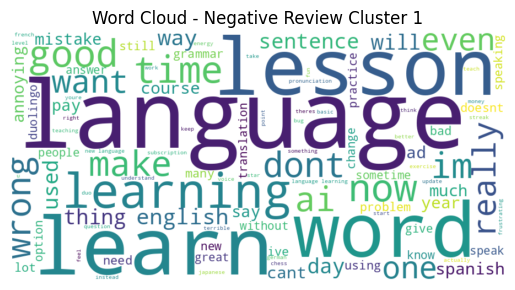

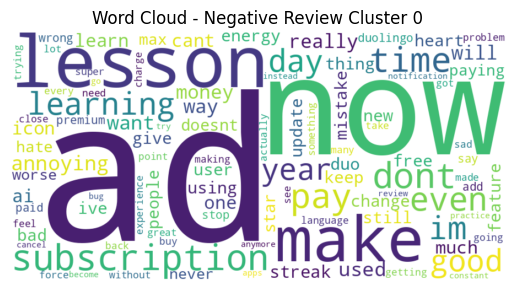

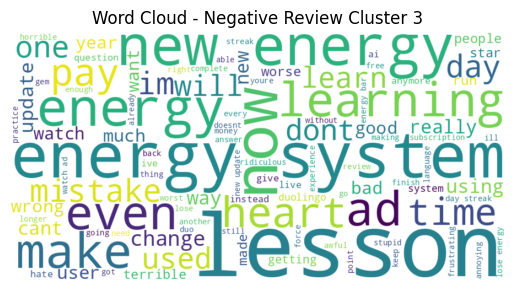

In [23]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Generate word clouds only for top 3 clusters
for cluster in top3_clusters:

    cluster_df = negative_reviews_range_sorted[
        negative_reviews_range_sorted['cluster'] == cluster
    ]

    cluster_texts = cluster_df['cleaned_content'].astype(str).tolist()
    combined_text = " ".join(cluster_texts)

    # Optional: add custom stopwords
    custom_stopwords = set(STOPWORDS)
    custom_stopwords.update(["app", "use", "get"])  # add domain-generic words if needed

    # Create word cloud
    wordcloud = WordCloud(
        width=900,
        height=450,
        background_color='white',
        stopwords=custom_stopwords,
        max_words=100
    ).generate(combined_text)

    # Plot one figure per cluster
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud - Negative Review Cluster {cluster}")
    plt.show()

# Key Insights from Negative Reviews

### 1. Flaws in the Energy System (Version 6+)
A large portion of negative reviews highlight issues with the energy system. Free users frequently report that their progress is blocked due to depleted energy, leading to frustration and a feeling of stalled learning.

### 2. AI Recommendations Are Problematic
Users criticize the AI-driven lesson recommendations, reporting low accuracy and repetitive lesson suggestions. Many feel the AI does not adapt properly to their learning needs, resulting in a frustrating experience.

### 3. Excessive Advertising Interruptions
Many users find the frequency of ads disruptive. Unlike entertainment apps, Duolingo users are here to learn, so the ads interrupt their focus. This issue is often compounded by the energy system, as users feel forced to watch ads to continue progress.

# Suggested App Improvements

### 1. Revise the Energy System
- Adjust the energy system so that energy is only depleted when mistakes are made, not simply by completing lessons.  
- Increase energy limits for free users or provide alternative ways to earn energy through daily activities.  
- Introduce a smoother progression system that reduces frustration from blocked lessons.  
- Offer clear communication about energy consumption and refill options.

### 2. Improve AI Lesson Recommendations
- Enhance the AI algorithm to reduce repetition and better adapt to individual learning pace.  
- Allow users to provide feedback on recommended lessons to refine AI suggestions.  
- Introduce optional “lesson variety” settings so users can control lesson rotation.  
- Add a setting for users to turn off AI recommendations entirely if they prefer.

### 3. Reduce Advertising Disruption
- Limit ad frequency for free users, especially when energy has been depleted.  
- Provide a clear distinction between learning and optional ad engagement.  
- Explore non-intrusive ad formats or incentives (e.g., optional ads for extra energy rather than forced interruptions).